Dataset shape: (1717094, 54)
          Order ID Order Date     Customer Name        City         Country  \
0  BN-2011-7407039 2011-01-01        Ruby Patel   Stockholm          Sweden   
1  AZ-2011-9050313 2011-01-03    Summer Hayward   Southport  United Kingdom   
2  AZ-2011-6674300 2011-01-04  Devin Huddleston     Valence          France   
3  BN-2011-2819714 2011-01-04       Mary Parker  Birmingham  United Kingdom   
4   AZ-2011-617423 2011-01-05      Daniel Burke  Echirolles          France   

    Region      Segment  Ship Date     Ship Mode                 State  ...  \
0    North  Home Office 2011-01-05  Economy Plus             Stockholm  ...   
1    North     Consumer 2011-01-07       Economy               England  ...   
2  Central     Consumer 2011-01-08       Economy  Auvergne-Rhône-Alpes  ...   
3    North    Corporate 2011-01-09       Economy               England  ...   
4  Central  Home Office 2011-01-07      Priority  Auvergne-Rhône-Alpes  ...   

  asin title imgUrl  

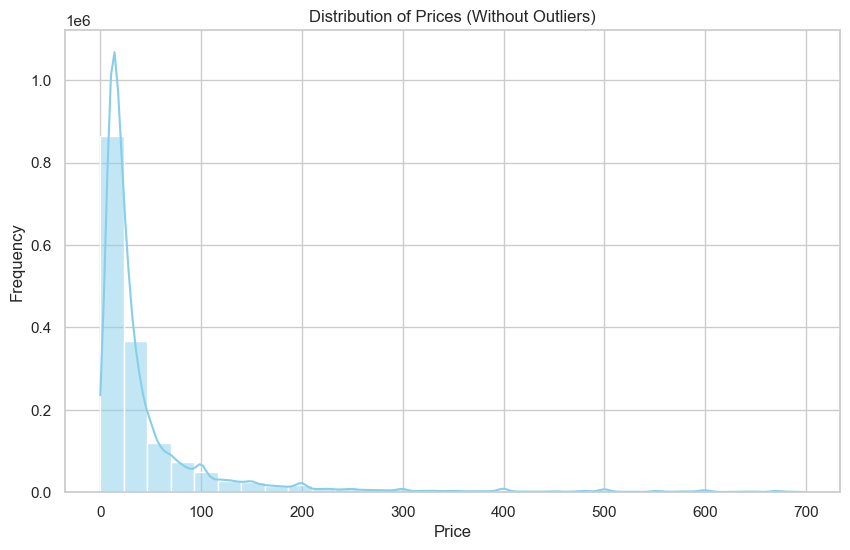

Original Dataset Size: 1717094
Filtered Dataset Size: 1627195
Number of Outliers Removed: 89899
Filtered Price Range: 0.0 - 699.0


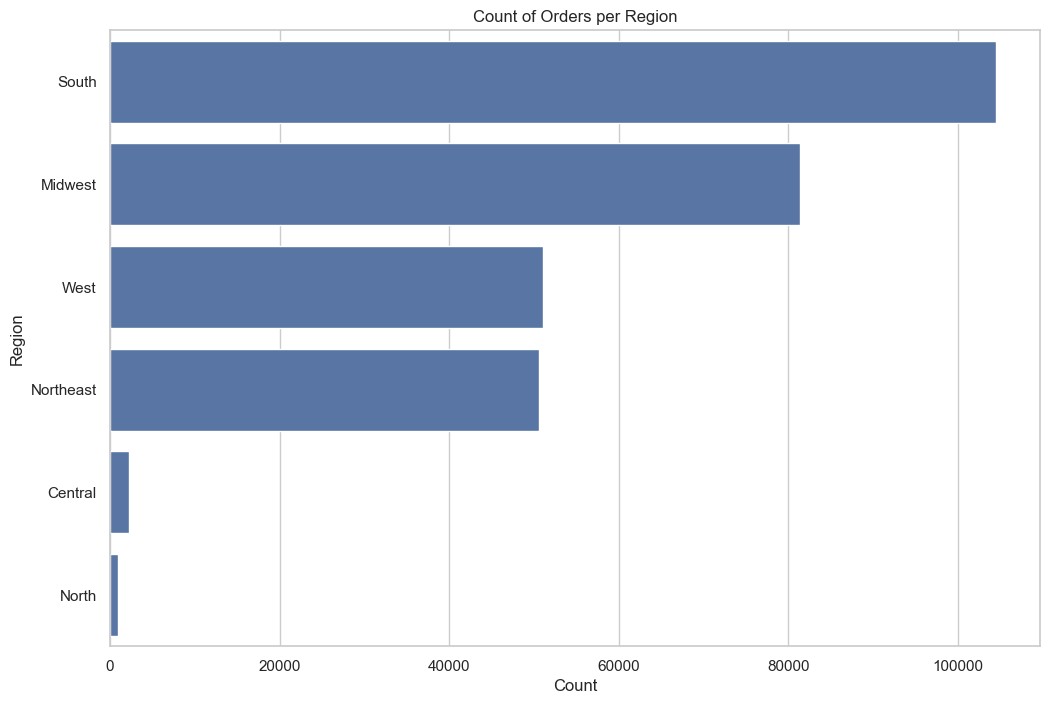

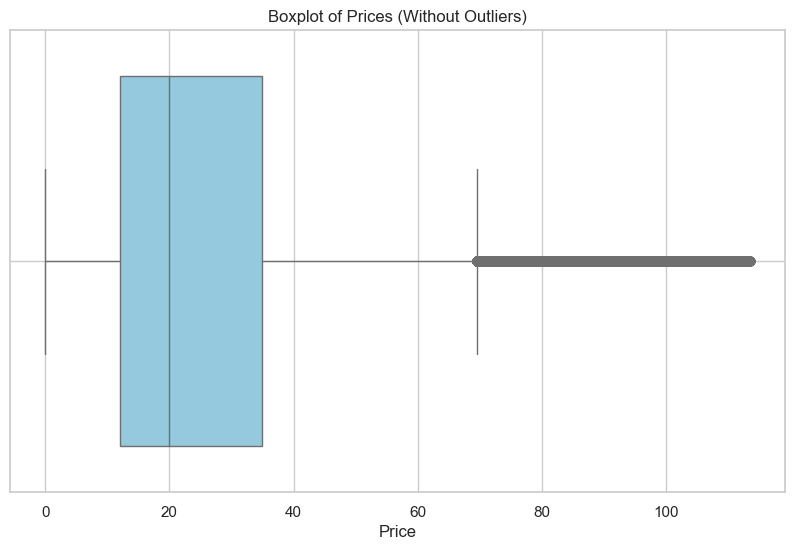

Original Dataset Size: 1717094
Filtered Dataset Size: 1472331
Number of Outliers Removed: 244763
Filtered Price Range: 0.0 - 113.51


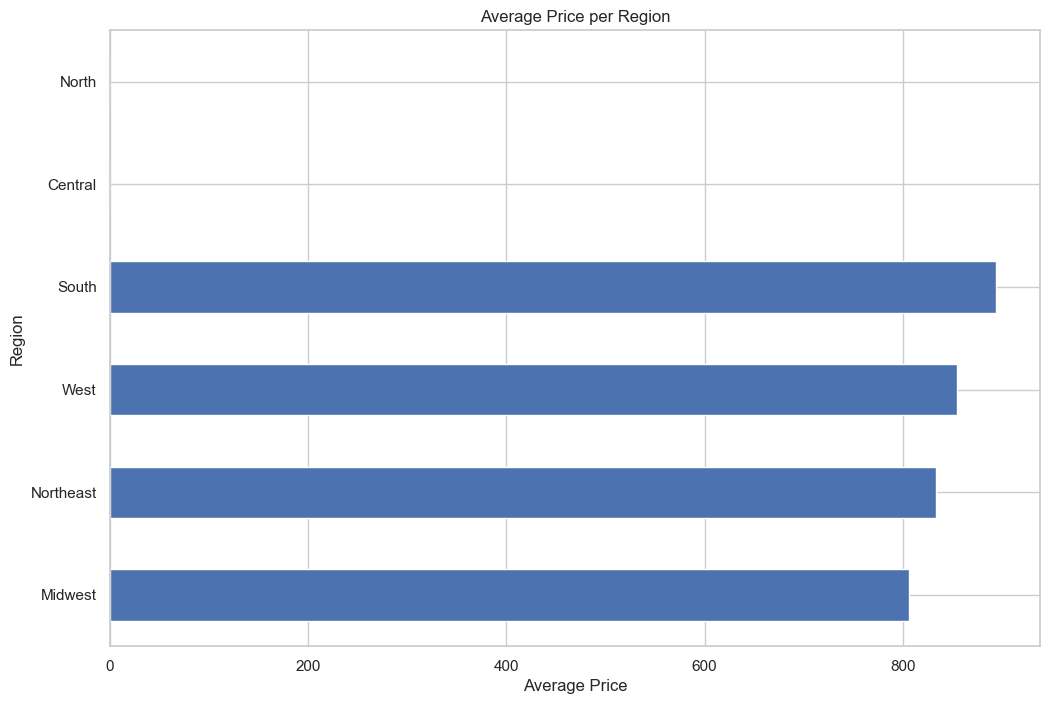

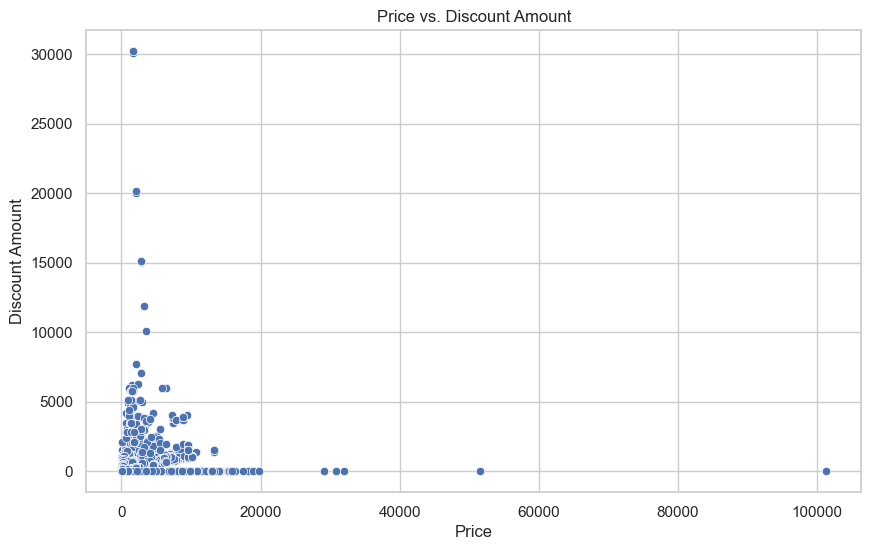

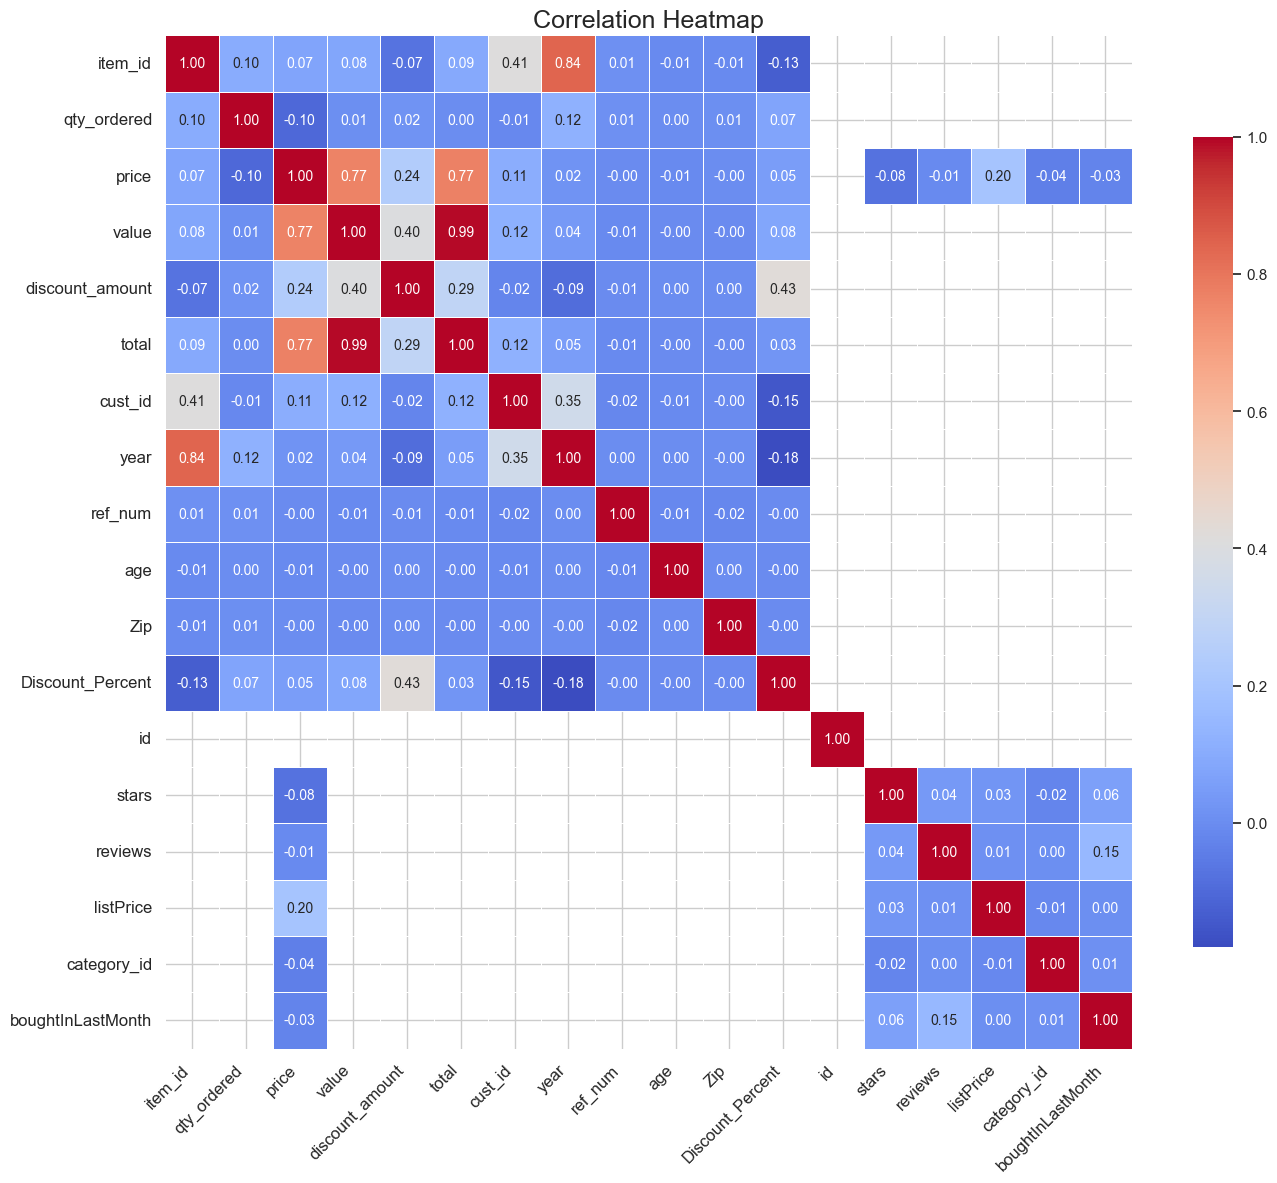

Region
South        104415
Midwest       81299
West          51080
Northeast     50531
Central        2234
North           950
Name: count, dtype: int64


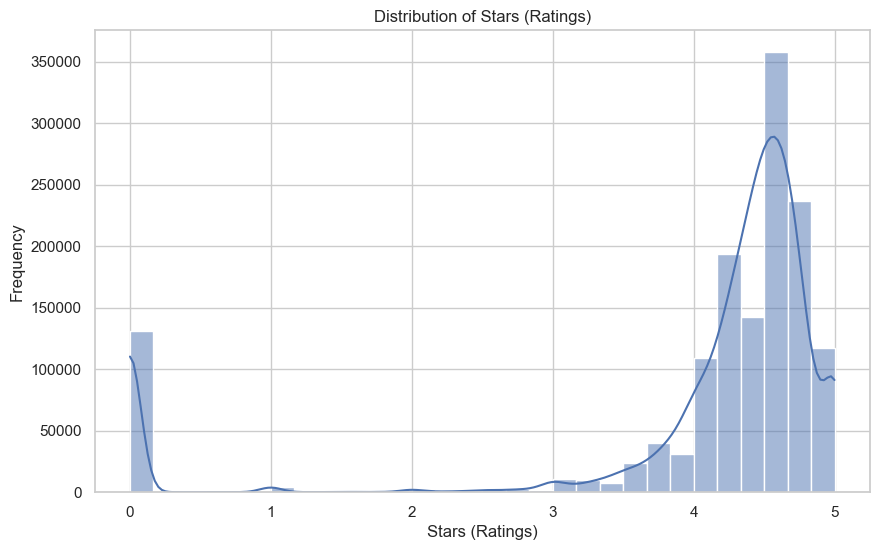

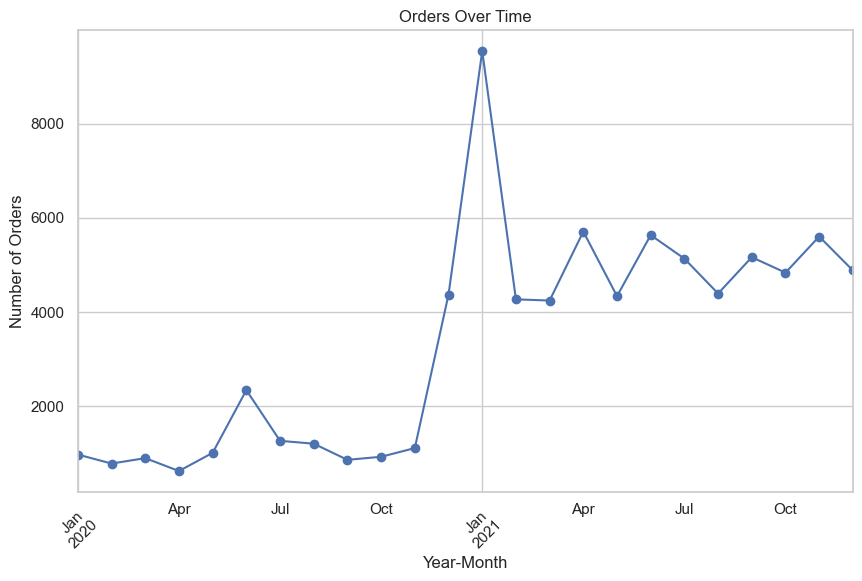

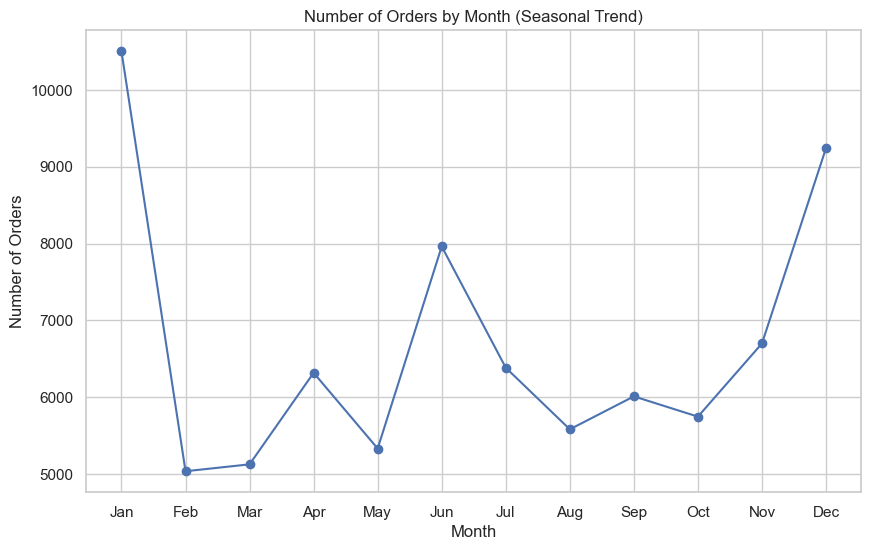

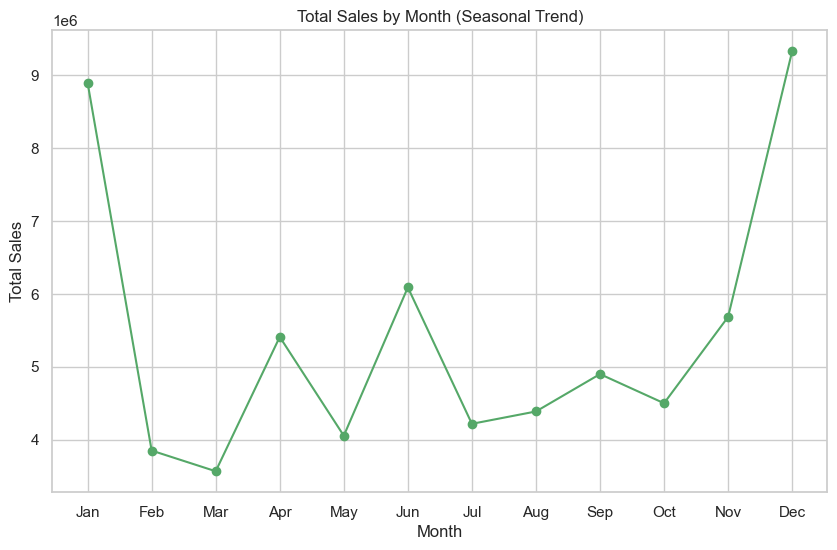

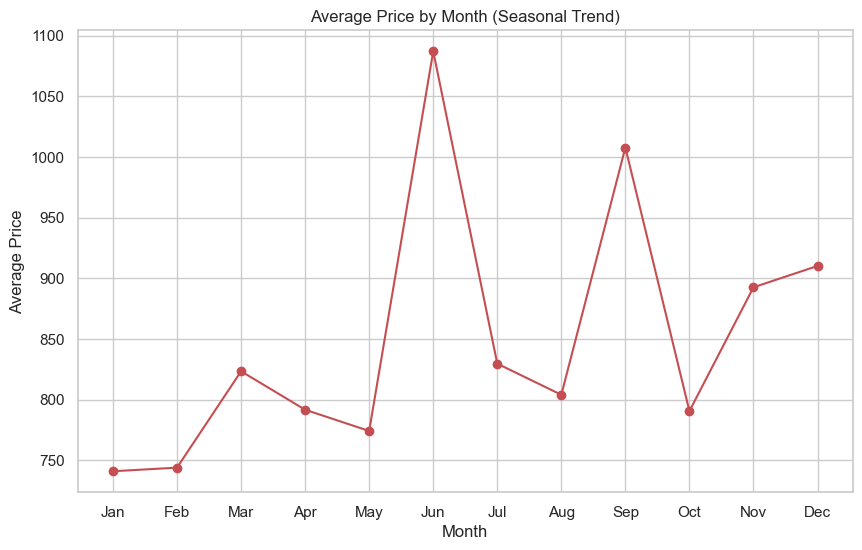

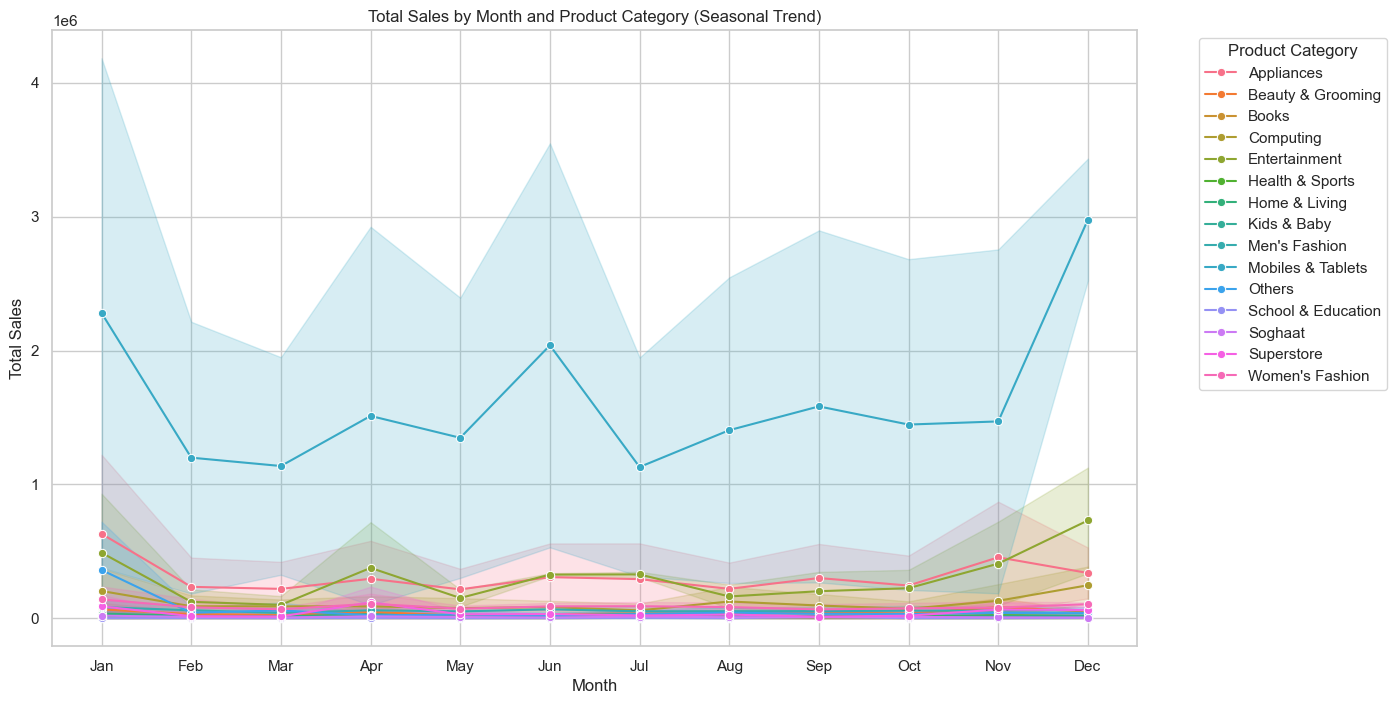

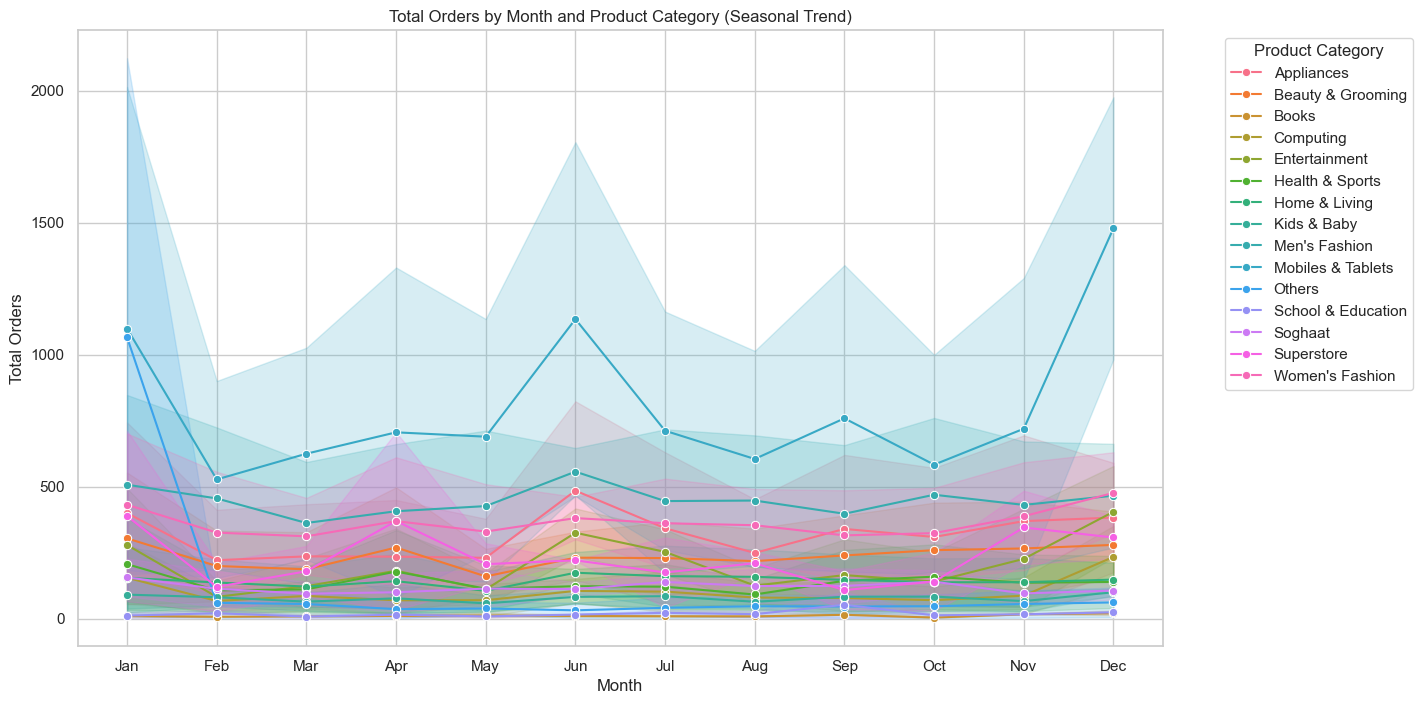

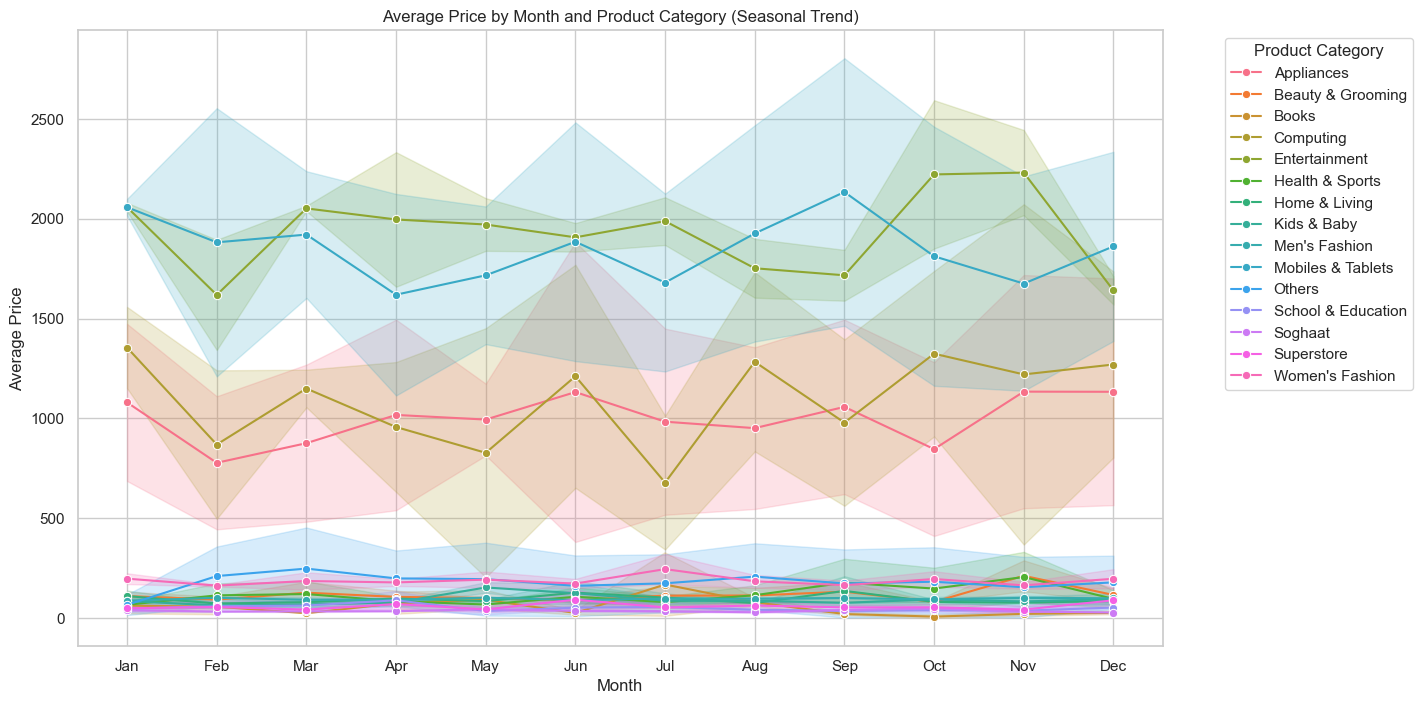

Mean Squared Error: 327757.86285150517
R2 Score: 0.4992508475785683


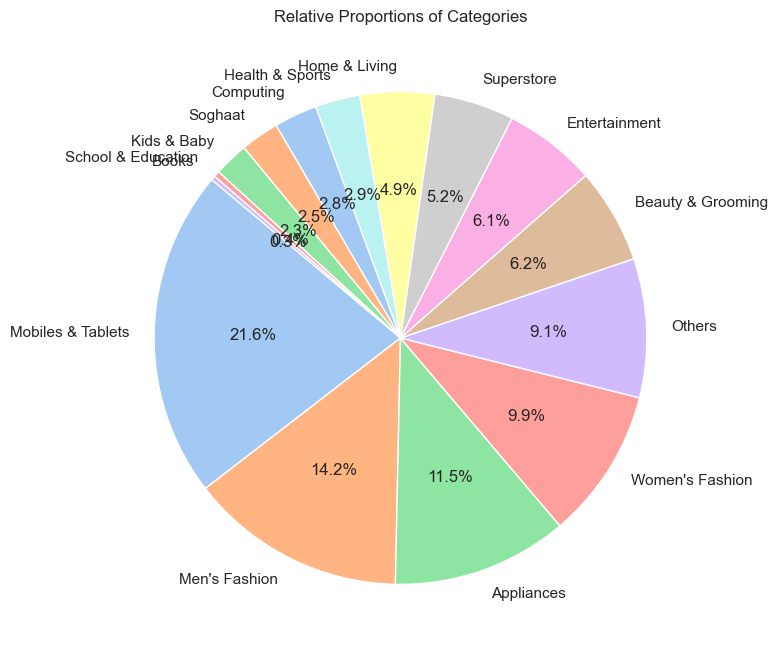

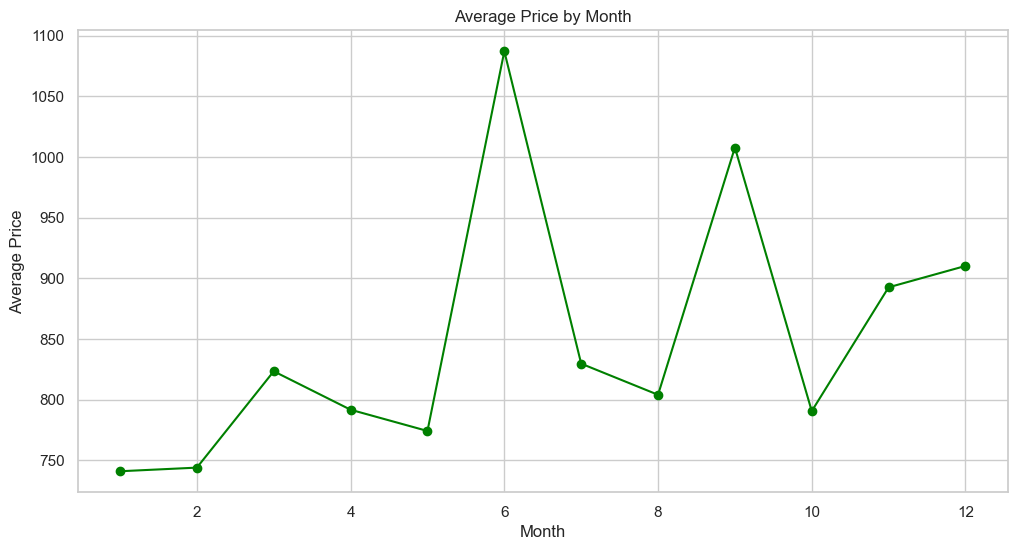

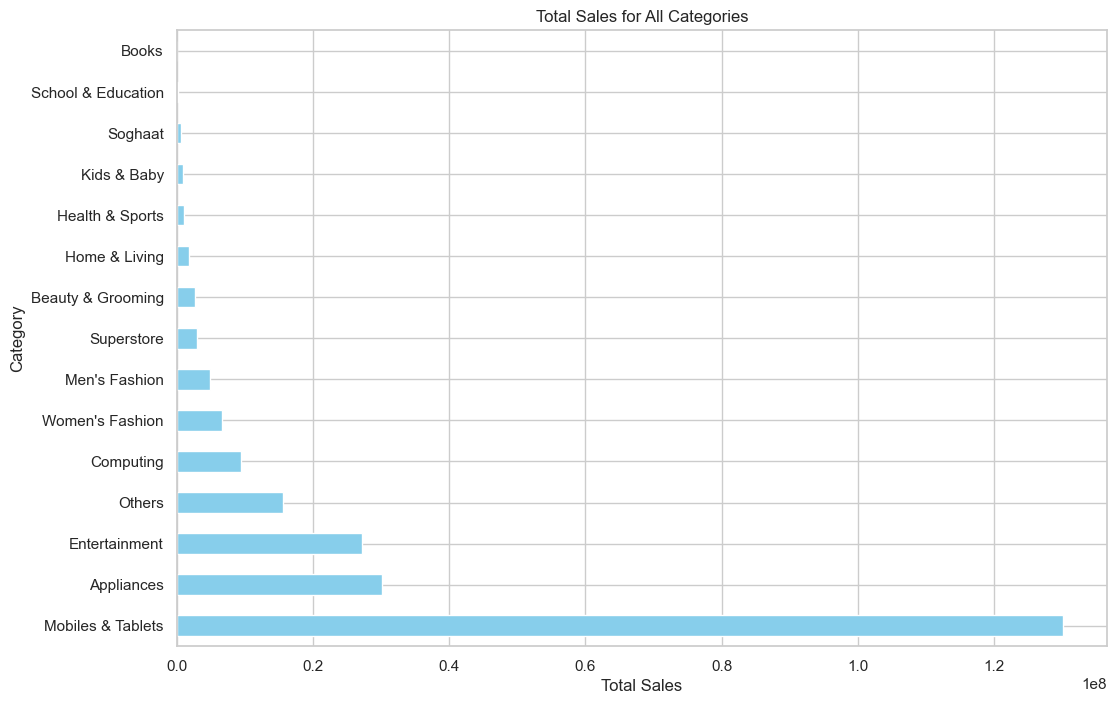

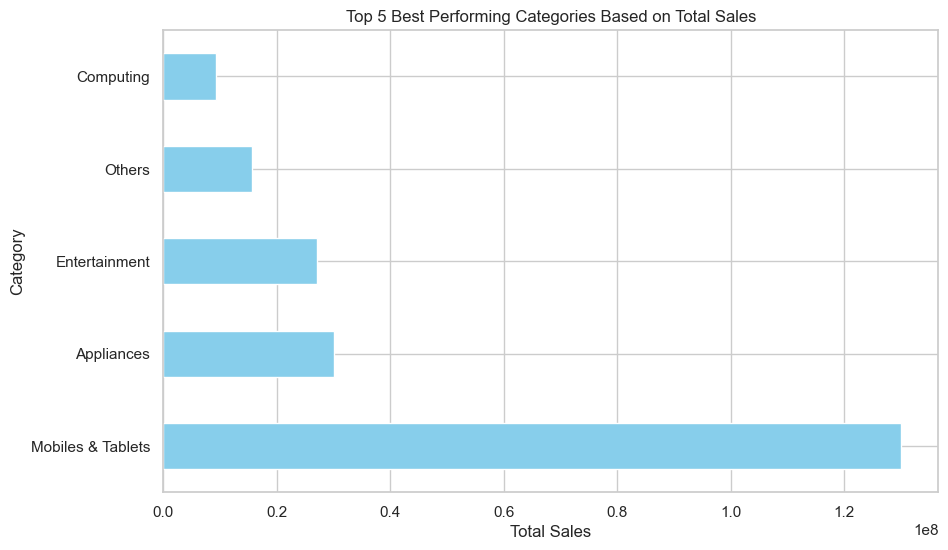

In [162]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Set styles for plots
sns.set(style="whitegrid")

# Step 2: Load Datasets
product_excel_path = 'DataSetFolder/Amazon product/P1-AmazingMartEU2.xlsx'
product_csv_path = 'DataSetFolder/Amazon Sales FY2020-21/Amazon Sales FY2020-21.csv'
product_folder_path = 'DataSetFolder/Amazon Products Dataset'

# Load datasets
product_excel_df = pd.read_excel(product_excel_path)
product_csv_df = pd.read_csv(product_csv_path, low_memory=False)

# Load all CSV files from the folder
csv_files = [f for f in os.listdir(product_folder_path) if f.endswith('.csv')]
product_folder_dfs = [pd.read_csv(os.path.join(product_folder_path, f)) for f in csv_files]

# Combine all datasets
combined_df = pd.concat([product_excel_df, product_csv_df] + product_folder_dfs, ignore_index=True)

# Step 3: Basic Data Exploration
print("Dataset shape:", combined_df.shape)
print(combined_df.head())
print(combined_df.info())

# Check for missing values
missing_values = combined_df.isnull().sum()
print(missing_values[missing_values > 0])

# Step 4: Clean Price Column (if applicable)
def clean_price_column(column):
    return pd.to_numeric(column.str.replace('₹', '').str.replace(',', ''), errors='coerce')

# Apply cleaning function to the 'price' and 'discount_amount' columns if they exist
# Uncomment if applicable
# combined_df['price'] = clean_price_column(combined_df['price'])
# combined_df['discount_amount'] = clean_price_column(combined_df['discount_amount'])

# Step 5: Data Reduction (drop unnecessary columns)
columns_to_drop = ['order_id', 'user_name', 'Phone No.', 'Sign in date']  # Example of columns to drop
combined_df_cleaned = combined_df.drop(columns=columns_to_drop, errors='ignore')

# Step 6: Univariate Analysis - Distribution of Prices (Removing Outliers)
# Calculate the 95th percentile as the upper limit
upper_limit = combined_df_cleaned['price'].quantile(0.95)

# Filter the dataset to exclude outliers
filtered_df = combined_df_cleaned[combined_df_cleaned['price'] <= upper_limit]

# Plot the distribution of prices without outliers
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['price'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Prices (Without Outliers)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Print basic statistics of the filtered data
print(f"Original Dataset Size: {combined_df_cleaned.shape[0]}")
print(f"Filtered Dataset Size: {filtered_df.shape[0]}")
print(f"Number of Outliers Removed: {combined_df_cleaned.shape[0] - filtered_df.shape[0]}")
print(f"Filtered Price Range: {filtered_df['price'].min()} - {filtered_df['price'].max()}")


# Step 7: Count of Orders per Region
plt.figure(figsize=(12, 8))
sns.countplot(y='Region', data=combined_df_cleaned, order=combined_df_cleaned['Region'].value_counts().index)
plt.title('Count of Orders per Region')
plt.xlabel('Count')
plt.ylabel('Region')
plt.show()

# Step 8: Outlier Detection and Boxplot of Prices (Removing Outliers)
# Calculate the Interquartile Range (IQR)
Q1 = combined_df_cleaned['price'].quantile(0.25)
Q3 = combined_df_cleaned['price'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataset to exclude outliers
filtered_df = combined_df_cleaned[
    (combined_df_cleaned['price'] >= lower_bound) &
    (combined_df_cleaned['price'] <= upper_bound)
]

# Plot the boxplot without outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_df['price'], color='skyblue')
plt.title('Boxplot of Prices (Without Outliers)')
plt.xlabel('Price')
plt.grid(True)
plt.show()

# Print statistics for the filtered data
print(f"Original Dataset Size: {combined_df_cleaned.shape[0]}")
print(f"Filtered Dataset Size: {filtered_df.shape[0]}")
print(f"Number of Outliers Removed: {combined_df_cleaned.shape[0] - filtered_df.shape[0]}")
print(f"Filtered Price Range: {filtered_df['price'].min()} - {filtered_df['price'].max()}")


# Step 9: Average Price per Region
avg_price_per_region = combined_df_cleaned.groupby('Region')['price'].mean().sort_values()
avg_price_per_region.plot(kind='barh', figsize=(12, 8))
plt.title('Average Price per Region')
plt.xlabel('Average Price')
plt.ylabel('Region')
plt.show()

# Step 10: Price vs. Discount Analysis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='discount_amount', data=combined_df_cleaned)
plt.title('Price vs. Discount Amount')
plt.xlabel('Price')
plt.ylabel('Discount Amount')
plt.show()

# Step 11: Correlation Heatmap with Full Grid and Clear Numbers
plt.figure(figsize=(14, 12))  # Adjust the figure size for better visibility

# Select numeric columns for correlation calculation
numeric_cols = combined_df_cleaned.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_cols.corr()

# Plot the heatmap without masking the upper triangle
sns.heatmap(
    correlation_matrix,
    cmap='coolwarm',  # Color map
    annot=True,  # Show correlation values
    fmt=".2f",  # Format values to 2 decimal places
    annot_kws={"size": 10},  # Increase font size for annotations
    cbar_kws={"shrink": 0.8},  # Shrink color bar
    square=False,  # Allow rectangular cells if necessary
    linewidths=0.5  # Add grid lines
)

plt.title('Correlation Heatmap', fontsize=18)  # Increase title font size
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and adjust x-axis labels
plt.yticks(fontsize=12)  # Adjust y-axis labels
plt.tight_layout()  # Ensure everything fits well
plt.show()


# Step 12: Value Counts for Categorical Variables (e.g., Region)
print(combined_df_cleaned['Region'].value_counts())

# Step 13: Distribution of Stars (Ratings)
# Assuming the 'stars' column is in one of the product CSV files
stars_df = product_folder_dfs[1]  # Adjust index if necessary
plt.figure(figsize=(10, 6))
sns.histplot(stars_df['stars'].dropna(), bins=30, kde=True)
plt.title('Distribution of Stars (Ratings)')
plt.xlabel('Stars (Ratings)')
plt.ylabel('Frequency')
plt.show()

# Additional EDA: Orders Over Time
combined_df['order_date'] = pd.to_datetime(combined_df['order_date'], errors='coerce')
combined_df['year_month'] = combined_df['order_date'].dt.to_period('M')

monthly_orders = combined_df.groupby('year_month').size()
plt.figure(figsize=(10, 6))
monthly_orders.plot(kind='line', marker='o')
plt.title('Orders Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()

# Seasonal Trend: Group by Month
combined_df['month'] = combined_df['order_date'].dt.month

# Plot number of orders per month (Seasonal Trend)
monthly_order_count = combined_df.groupby('month').size()
plt.figure(figsize=(10, 6))
monthly_order_count.plot(kind='line', marker='o', color='b')
plt.title('Number of Orders by Month (Seasonal Trend)')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

# Seasonal Trend: Total Sales by Month
monthly_sales = combined_df.groupby('month')['total'].sum()
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='line', marker='o', color='g')
plt.title('Total Sales by Month (Seasonal Trend)')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

# Seasonal Trend: Average Price per Month
avg_price_per_month = combined_df.groupby('month')['price'].mean()
plt.figure(figsize=(10, 6))
avg_price_per_month.plot(kind='line', marker='o', color='r')
plt.title('Average Price by Month (Seasonal Trend)')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

# Seasonal Trend for Product Categories by Year and Month

# Step 1: Extract Year and Month for Seasonal Trend
combined_df['year'] = combined_df['order_date'].dt.year
combined_df['month'] = combined_df['order_date'].dt.month

# Step 2: Group by Year, Month, and Category
category_monthly_sales = combined_df.groupby(['year', 'month', 'category']).agg(
    total_sales=('total', 'sum'),
    total_orders=('order_id', 'count'),
    avg_price=('price', 'mean')
).reset_index()

# Step 3: Plot Total Sales by Year, Month, and Product Category (Seasonal Trend)
plt.figure(figsize=(14, 8))
sns.lineplot(x='month', y='total_sales', hue='category', data=category_monthly_sales, marker='o')
plt.title('Total Sales by Month and Product Category (Seasonal Trend)')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Step 4: Plot Total Orders by Year, Month, and Product Category (Seasonal Trend)
plt.figure(figsize=(14, 8))
sns.lineplot(x='month', y='total_orders', hue='category', data=category_monthly_sales, marker='o')
plt.title('Total Orders by Month and Product Category (Seasonal Trend)')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.xticks(np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Step 5: Plot Average Price by Year, Month, and Product Category (Seasonal Trend)
plt.figure(figsize=(14, 8))
sns.lineplot(x='month', y='avg_price', hue='category', data=category_monthly_sales, marker='o')
plt.title('Average Price by Month and Product Category (Seasonal Trend)')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Step 15: Regression Analysis - Linear Regression
# Use stars instead of rating
features = combined_df[['price', 'discount_amount', 'stars']]
target = combined_df['total']

# Handle missing values
features = features.fillna(features.mean())
target = target.fillna(target.mean())

# Split data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

# Step 16: Relative Proportions of Categories
if 'category' in combined_df.columns:
    plt.figure(figsize=(10, 8))
    category_counts = combined_df['category'].value_counts()
    category_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
    plt.title('Relative Proportions of Categories')
    plt.ylabel('')  # Removes the default y-label
    plt.show()

# Average Price by Month
if 'price' in combined_df.columns:
    combined_df['month'] = combined_df['order_date'].dt.month
    avg_price_per_month = combined_df.groupby('month')['price'].mean()
    plt.figure(figsize=(12, 6))
    avg_price_per_month.plot(kind='line', marker='o', color='green')
    plt.title('Average Price by Month')
    plt.xlabel('Month')
    plt.ylabel('Average Price')
    plt.grid(True)
    plt.show()

# Step: Total Sales for All Categories

# Grouping by 'category' and calculating the total sales for all categories
category_sales_all = combined_df.groupby('category')['total'].sum().sort_values(ascending=False)

# Plotting the graph for all categories
plt.figure(figsize=(12, 8))
category_sales_all.plot(kind='barh', color='skyblue')
plt.title('Total Sales for All Categories')
plt.xlabel('Total Sales')
plt.ylabel('Category')
plt.grid(True)
plt.show()

# Step: Top 5 Best Performing Categories Based on Total Sales

# Grouping by 'category' and calculating the total sales
category_sales = combined_df.groupby('category')['total'].sum().sort_values(ascending=False)

# Selecting the top 5 categories
top_5_categories = category_sales.head(5)

# Plotting the graph
plt.figure(figsize=(10, 6))
top_5_categories.plot(kind='barh', color='skyblue')
plt.title('Top 5 Best Performing Categories Based on Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Category')
plt.grid(True)
plt.show()

